In [10]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import binom, rv_discrete, poisson, norm, expon

import matplotlib.pyplot as plt
import seaborn as sns


<style>
table
{
    margin: auto;
}
</style>

# Dynamic Models




## Big-Rig Service Center

You manage the Big-Rig Service Center, which runs a thriving business performing repairs on large trucks.

The number of trucks arriving at the facility in need of repair each morning is well-modeled by a Poisson random variable with a mean value of 3.8.

If you have a free service bay available for an arriving truck, you start servicing it immediately.

Trucks that you cannot immediately accommodate with a free service bay do not wait, but go to a competitor’s facility instead.

You currently have 5 service bays, but since you frequently have to turn away business, you are considering expanding to **6, 7, or possibly 8 bays.**

Including debt service, insurance, and taxes, your costs for these expansion options, converted to a daily payment, would be:

|   Total Bays   | Daily Cost |
| :------------: | :--------: |
| 6 (add 1 bay)  |  $\$175$   |
| 7 (add 2 bays) |  $\$325$   |
| 8 (add 3 bays) |  $\$475$   |

Repairing each truck can take either 1, 2, or 3 full days; and you cannot tell in advance how long the work will take.

There is a 30% chance that a truck can be completed by the end of one day, in which case you charge $800.

Given that service cannot be completed the first day, there is 75% chance it will be finished at the end of the next day, in which case your total charge is $1,500.

Otherwise, completing the service takes three full days or work, for which you charge $2,100.

Your operating costs are $425 per occupied service bay per day.

Should you expand your facility, and if so, how many service bays should you add? With this number of bays, what is the average number of service requests denied per day?

**5. Modify problem 4 in handout 3:**

Assume now that if a service cannot be completed the second day, there is 90% chance it will be finished at the end of the next day, in which case your total charge is $2,100.

In case if the service isn't finished in three days, the truck is returned in the condition "not fixed", and the company receives only $1,000.

In addition to the previously asked questions, provide statistics on the total number of trucks remaining "not fixed" during the testing period.


### Constants definions


In [11]:
# make 1000 trials for 100 days for different scenarios
N = 1000  # number of trials

cost_bay_scenarios = {5: 0, 6: 175, 7: 325, 8: 475}

n = 100  # number of days

truck_arrive_rvs = poisson.rvs(mu=3.8, size=n)


In [12]:
# make 1000 trials for 100 days for different scenarios
N = 1000  # number of trials

cost_bay_scenarios = {5: 0, 6: 175, 7: 325, 8: 475}

n = 100  # number of days

truck_arrive_rvs = poisson.rvs(mu=3.8, size=n)


class Simulation_bays:
    """simulation this problem with all conditions:
        cost_bay_scenarios = {5:0,6:175,7:325,8:475}
    """

    def __init__(self, bay_num, n):
        """initialize the number of bays"""
        self.bay_num = bay_num
        self.n = 100  # number of days

    def truck_arrive_rvs(self):
        """generate the truck arrivals"""
        return np.random.exponential(scale=3.8, size=self.n).astype(dtype=int)
        # problem here

    def df_bays(self):
        """create the dataframe to store the results"""

        colums = ['days', 'truck_arrivals', '1st_start', '2nd_start', '3rd_start', '1st_completed',
                  '2nd_completed', '3rd_completed', 'not_fixed', 'free_Bays_left', 'num_trucks_denied']
        df_bays = pd.DataFrame(columns=colums)
        df_bays['days'] = np.arange(self.n+1)
        df_bays.fillna(0, inplace=True)
        df_bays['truck_arrivals'][1:] = self.truck_arrive_rvs()
        df_bays['free_Bays_left'][0] = self.bay_num

        return df_bays

    def sim_bays(self):
        """simulate the results"""
        df_bays = self.df_bays()

        for i in range(1, self.n+1):
            self._extracted_from_sim_bays_6(df_bays, i)
        num_trucks_denied = df_bays['num_trucks_denied'].sum()

        # Calculate the profit
        revenue = df_bays['1st_completed'].sum() * 800 + df_bays['2nd_completed'].sum(
        ) * 1500 + df_bays['3rd_completed'].sum() * 2100 + df_bays['not_fixed'].sum() * 1000

        cost_operating = df_bays[['1st_start',
                                  '2nd_start', '3rd_start']].sum().sum() * 425

        cost_bay_scenarios = {5: 0, 6: 175, 7: 325, 8: 475}

        cost_add = 100 * cost_bay_scenarios[self.bay_num]

        profit = revenue - cost_operating - cost_add

        return profit, num_trucks_denied

    # TODO Rename this here and in `sim_bays`
    def _extracted_from_sim_bays_6(self, df_bays, i):
        df_bays.loc[i, '1st_start'] = np.minimum(
            df_bays['free_Bays_left'][i-1], df_bays['truck_arrivals'][i])
        df_bays.loc[i, '1st_completed'] = np.random.binomial(
            n=df_bays.loc[i, '1st_start'], p=0.3, size=1)
        df_bays.loc[i, '2nd_start'] = df_bays.loc[i-1,
                                                  '1st_start'] - df_bays.loc[i-1, '1st_completed']
        df_bays.loc[i, '2nd_completed'] = np.random.binomial(
            n=df_bays.loc[i, '2nd_start'], p=0.75, size=1)
        df_bays.loc[i, '3rd_start'] = df_bays.loc[i-1,
                                                  '2nd_start'] - df_bays.loc[i-1, '2nd_completed']
        df_bays.loc[i, '3rd_completed'] = np.random.binomial(
            n=df_bays.loc[i, '3rd_start'], p=0.9, size=1)
        # Not fixed
        df_bays.loc[i, 'not_fixed'] = df_bays.loc[i-1,
                                                  '3rd_start'] - df_bays.loc[i-1, '3rd_completed']

        df_bays.loc[i, 'free_Bays_left'] = self.bay_num - sum(df_bays.loc[i, ['1st_start', '2nd_start', '3rd_start']]) + sum(
            df_bays.loc[i, ['1st_completed', '2nd_completed', '3rd_completed']])
        df_bays.loc[i, 'num_trucks_denied'] = df_bays.loc[i,
                                                          'truck_arrivals'] - df_bays.loc[i, '1st_start']


Calculate the results


# Caution! slow(Improving)


In [13]:
# results_5_bays = []
# results_6_bays = []
# results_7_bays = []
# results_8_bays = []

# for _ in range(1000):
#     results_5_bays.append(Simulation_bays(5,100).sim_bays())
#     results_6_bays.append(Simulation_bays(6,100).sim_bays())
#     results_7_bays.append(Simulation_bays(7,100).sim_bays())
#     results_8_bays.append(Simulation_bays(8,100).sim_bays())


In [14]:
# results_6_bays = np.array(results_6_bays)
# results_6_bays[:,0].mean()


### Visualization


In [15]:
# mean_profits = []

# mean_denials = []

# results_lists = [results_5_bays,results_6_bays,results_7_bays,results_8_bays]

# for result in results_lists:
#     mean_profits.append(np.array(result)[:,0].mean())
#     mean_denials.append(np.array(result)[:,1].mean() / 100)

# result_df = pd.DataFrame({'mean_profits':list(mean_profits),'mean_denials':list(mean_denials)},index=['5_bays','6_bays','7_bays','8_bays'])


In [16]:
# result_df


In [17]:
# _, axes = plt.subplots(1,2,figsize=(12,8))

# axes[0].bar(result_df.index,result_df['mean_profits'])
# axes[0].set_title('Mean Profit')
# axes[0].set_xlabel('Number of Bays')

# axes[1].bar(result_df.index,result_df['mean_denials'])
# axes[1].set_title('Mean Trucks Denied')
# axes[1].set_xlabel('Number of Bays')

# plt.show()


In [18]:
# mean_denials




## Modified problem of Big-Rig Service Center

Assume now that if a service cannot be completed the second day, there is 90% chance it will be finished at the end of the next day, in which case your total charge is $\$2,100$.

In case if the service isn't finished in three days, the truck is returned in the condition "not fixed", and the company receives only $1,000. In addition to the previously asked questions, provide statistics on the total number of trucks remaining "not fixed" during the testing period.

<style>
table
{
    margin: auto;
}
</style>

#### Original Problem

You manage the Big-Rig Service Center, which runs a thriving business performing repairs on large trucks.

The number of trucks arriving at the facility in need of repair each morning is well-modeled by a Poisson random variable with a mean value of 3.8.

If you have a free service bay available for an arriving truck, you start servicing it immediately.

Trucks that you cannot immediately accommodate with a free service bay do not wait, but go to a competitor’s facility instead.

You currently have 5 service bays, but since you frequently have to turn away business, you are considering expanding to **6, 7, or possibly 8 bays.**

Including debt service, insurance, and taxes, your costs for these expansion options, converted to a daily payment, would be:

|   Total Bays   | Daily Cost |
| :------------: | :--------: |
| 6 (add 1 bay)  |  $\$175$   |
| 7 (add 2 bays) |  $\$325$   |
| 8 (add 3 bays) |  $\$475$   |

Repairing each truck can take either 1, 2, or 3 full days; and you cannot tell in advance how long the work will take.

There is a 30% chance that a truck can be completed by the end of one day, in which case you charge $800.

Given that service cannot be completed the first day, there is 75% chance it will be finished at the end of the next day, in which case your total charge is $1,500.

Otherwise, completing the service takes three full days or work, for which you charge $2,100.

Your operating costs are $425 per occupied service bay per day.

Should you expand your facility, and if so, how many service bays should you add? With this number of bays, what is the average number of service requests denied per day?


In [19]:
# make 1000 trials for 100 days for different scenarios
N = 1000  # number of trials

cost_bay_scenarios = {5: 0, 6: 175, 7: 325, 8: 475}

n = 100  # number of days


In [20]:
# initialize the simulation, create the the arrays for calculating with zeros:
# truck_arrivals_arr: the number of trucks arrived at the truck shop every day
# num_trucks_denied_arr: the number of trucks denied when they arrived at the truck shop every day
# start_1st_arr: the number of trucks at the truck shop at the start of first day
# completed_arr: the number of trucks completed their repair every day
# start_2nd_arr: the number of trucks at the truck shop at the start of second day
# completed_2nd_arr: the number of trucks completed their repair at the end of second day
# start_3rd_arr: the number of trucks at the truck shop at the start of third day
# completed_3rd_arr: the number of trucks completed their repair at the end of third day
# not_fixed_arr: the number of trucks not fixed at the end of the day
# free_bays_arr: the number of free bays at the end of the day

arr_names = [
    'truck_arrivals_arr', 'start_1st_arr', 'start_2nd_arr', 'start_3rd_arr',
    'completed_1st_arr', 'completed_2nd_arr', 'completed_3rd_arr',
    'not_fixed_arr', 'free_Bays_left_arr', 'num_trucks_denied_arr'
]

for name in arr_names:
    exec(f"{name} = np.zeros(n + 1).astype(dtype=int)")


In [21]:
# Generate the truck arrivals rvs with Poisson distribution
truck_arrivals_arr[0] = 0
truck_arrivals_arr[1:] = stats.poisson(mu=3.8).rvs(size=n)


In [22]:
# Build the simulation function
def sim_bays_array(num_bays):
    # At the very beginning, the number of free bays is equal to the number of bays since there are no trucks arriving yet.
    free_Bays_left_arr[0] = num_bays

    for i in range(1, n + 1):
        start_1st_arr[i] = np.minimum(free_Bays_left_arr[i - 1],
                                      truck_arrivals_arr[i])
        # the number of trucks at the truck shop at the start of the day is the minimum of the number of free bays and the number of trucks arrived at the truck shop，if the number of trucks arrived at the truck shop is larger than the number of free bays, the trucks arrival will be denied.
        completed_1st_arr[i] = binom(n=start_1st_arr[i], p=0.3).rvs()
        # the number of trucks completed their repair at the start of the day is the number of trucks at the truck shop at the start of the day, which is randomly generated by the binomial distribution from the nunmber of trucks in the beggining of the day with the probability of completion of the repair is 0.3

        start_2nd_arr[i] = start_1st_arr[i - 1] - completed_1st_arr[i - 1]
        # the number of trucks at the truck shop at the start of the second day is the number of trucks at the truck shop at the start of the first day minus the number of trucks completed their repair at the start of the first day
        completed_2nd_arr[i] = binom(n=start_2nd_arr[i], p=0.75).rvs()
        # Similarly, the number of trucks completed their repair at the start of the second day is randomly generated by the binomial distribution from the nunmber of trucks in the beggining of the day with the probability of completion of the repair is 0.75

        start_3rd_arr[i] = start_2nd_arr[i - 1] - completed_2nd_arr[i - 1]
        completed_3rd_arr[i] = binom(n=start_3rd_arr[i], p=0.9).rvs()

        # Not fixed
        not_fixed_arr[i] = start_3rd_arr[i - 1] - completed_3rd_arr[i - 1]
        # the number of trucks not fixed at the end of the day is the number of trucks at the truck shop at the start of the third day minus the number of trucks completed their repair at the start of the third day

        free_Bays_left_arr[i] = num_bays - (
            start_1st_arr[i] + start_2nd_arr[i] + start_3rd_arr[i]).sum() + (
                completed_1st_arr[i] + completed_2nd_arr[i] +
                completed_3rd_arr[i]).sum()
        # the number of free bays at the end of each day is the number of bays minus the sum of number of trucks at the truck shop at the start of each day plus the sum of number of trucks completed their repair at the start of each day

        num_trucks_denied_arr[i] = truck_arrivals_arr[i] - start_1st_arr[i]
        # if the number of trucks arrived at the truck shop is larger than the number of free bays, the trucks arrival will be denied.

        # Calculate the profit
        num_trucks_denied = num_trucks_denied_arr.sum()

        revenue = completed_1st_arr.sum() * 800 + completed_2nd_arr.sum(
        ) * 1500 + completed_3rd_arr.sum() * 2100 + not_fixed_arr.sum() * 1000

        cost_operating = (start_1st_arr + start_2nd_arr +
                          start_3rd_arr).sum() * 425

        # cost_bay_scenarios = {5: 0, 6: 175, 7: 325, 8: 475}
        cost_add = 100 * cost_bay_scenarios[num_bays]

        profit = revenue - cost_operating - cost_add

    return profit, num_trucks_denied


In [23]:
# Creat the results arrays for storing the results
results = [
    'results_5_bays', 'results_6_bays', 'results_7_bays', 'results_8_bays'
]

for name in results:
    exec(f"{name} = np.empty((N, 2), dtype=int)")


In [24]:
for i in range(N):
    results_5_bays[i] = sim_bays_array(num_bays=5)
    results_6_bays[i] = sim_bays_array(num_bays=6)
    results_7_bays[i] = sim_bays_array(num_bays=7)
    results_8_bays[i] = sim_bays_array(num_bays=8)


### Visualization


In [25]:
# make the result dataframe
mean_profits = []

mean_denials = []

index_names = ['5_bays', '6_bays', '7_bays', '8_bays']

results_lists = [
    results_5_bays, results_6_bays, results_7_bays, results_8_bays
]

for result in results_lists:
    mean_profits.append(np.array(result)[:, 0].mean())
    mean_denials.append(np.array(result)[:, 1].mean() / 100)

result_df = pd.DataFrame(
    {
        'mean_profits': list(mean_profits),
        'mean_denials': list(mean_denials)
    },
    index=index_names)

result_df


,mean_profits,mean_denials
5_bays,138574.125,1.36788
6_bays,142607.675,0.99345
7_bays,144907.575,0.68865
8_bays,143751.275,0.44915


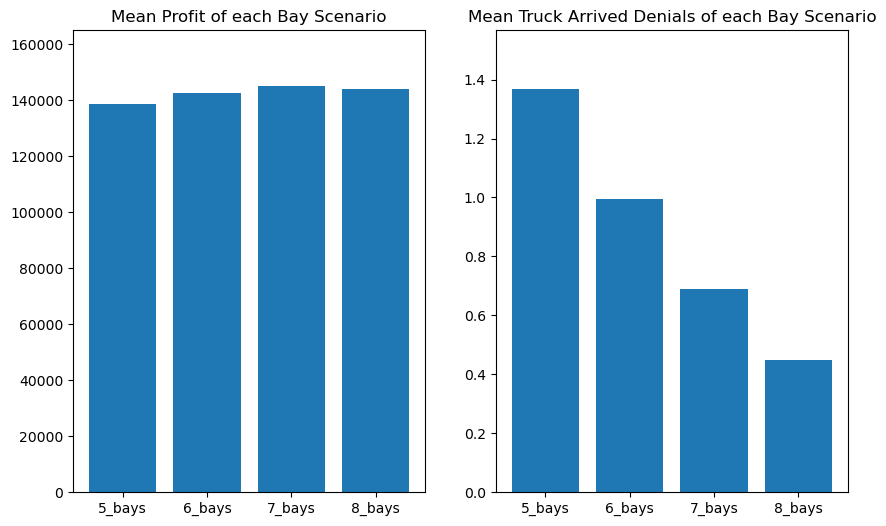

In [26]:
_, axes = plt.subplots(1, 2, figsize=(10, 6))

axes[0].bar(result_df.index, result_df['mean_profits'])
axes[0].set(ylim=(0, np.max(mean_profits) + 20000),
            title='Mean Profit of each Bay Scenario')

axes[1].bar(result_df.index, result_df['mean_denials'])
axes[1].set(ylim=(0, np.max(mean_denials) + 0.2),
            title='Mean Truck Arrived Denials of each Bay Scenario')

plt.show()


In [27]:
sol = np.argmax(mean_profits)

index_names[sol]

print(
    f"\nFrom the plots and dataframe, the best bay scenario is {index_names[sol]} with a mean profit of ${mean_profits[sol]} and a mean truck arrived denials of {mean_denials[sol]}."
)



From the plots and dataframe, the best bay scenario is 7_bays with a mean profit of $144907.575 and a mean truck arrived denials of 0.68865.


## Car repair

The Gotham Taxi Company has a fleet of 500 taxicabs. On any given day of use, a taxi has an 0.4% chance of breaking down. Broken-down taxis are towed overnight to the company repair shop. They return to service the day after they are fixed. Each day a taxi spends in the shop costs the company $350 in lost profits.
There are three mechanics Gotham is considering hiring to work in the repair shop: Larry, Moe and Curly. Each can fix one to three taxis per day.

- Larry would cost the company $300 per day. On any given day, there is 20% probability he can only fix one taxi, and a 40% probability he will be able to fix either two or three.

- Moe costs $250 per day. He has an equal probability of being able to fix either one, two, or three taxis on any given day.

- Curly costs $200 per day. On any given day, there is a 50% chance he can fix only one cab, a 30% chance he will be able fix two, and a 20% chance that he will be able to fix three.

The company may hire any combination of the three mechanics: any one, any two, or all three.

**Explain why you can tell, prior to performing any simulation, that the option of hiring just Curly will not be workable. ** `explain this`

Simulate each possibility by **200 trials of 100 days** each. Which possibility gives them the lowest average cost? What is the average number of taxis in the shop when you adopt this policy?


In [28]:
from itertools import product


In [41]:
# Create the assign matrix for mechanics


def assign_matrix(*cols):
    '''
    Assigns a 0-1 matrix for each cols
    '''
    matrix_0_1 = list(product([0, 1], repeat=len(cols)))
    return pd.DataFrame([*matrix_0_1], columns=cols)


In [42]:
hr_df = assign_matrix('Larry', 'Curly', 'Moe')
hr_df


,Larry,Curly,Moe
0,0,0,0
1,0,0,1
2,0,1,0
3,0,1,1
4,1,0,0
5,1,0,1
6,1,1,0
7,1,1,1


In [43]:
# drop the senario  [0 0 0], which means no one hired.

hr_df.drop(hr_df.iloc[:1].index, inplace=True)

hr_df.reset_index(drop=True, inplace=True)


In [44]:
# calcualte the wage for mechanics in different senarios
wage = [300, 200, 250]
hr_wage = hr_df.dot(wage)

cost_mechanics = hr_wage * 101
cost_mechanics


0    25250
1    20200
2    45450
3    30300
4    55550
5    50500
6    75750
dtype: int64

In [45]:
# generate repaired cars random variable for each mechanic
def repairs(names, cars, probs, days=101):
    repair_dict = {name: stats.rv_discrete(values=(car, prob)).rvs(
        size=days) for name, car, prob in zip(names, cars, probs)}

    return pd.DataFrame(repair_dict)


# import the parameters of each mechanic
names = ('Larry', 'Curly', 'Moe')
cars = ((1, 2, 3), (1, 2, 3), (1, 2, 3))
probs = ((0.2, 0.4, 0.4), (1 / 3, 1 / 3, 1 / 3), (0.5, 0.3, 0.2))

repair_df = repairs(
    names, cars,
    probs)  # generate the repairing cars random variable for each mechanic


In [46]:
repair_7 = repair_df.dot(hr_df.T).to_dict(
)  # combine the repairing cars random variable of each mechanic with the assignment matrix

repair_7['cars_broken'] = stats.binom(n=500, p=0.004).rvs(
    size=101)  # generate the number of broken cars every day


In [47]:
# make the day start and end labels for the scenarios
ls_end = []
ls_start = []
for i in range(7):
    ls_end.append(f"{i}_end")
    ls_start.append(f"{i}_start")


In [48]:
# Build the simulation function with Python Dictionary approach (fast while take more Memory)


def repairTrials_dic():
    """initialize the simulation"""
    days = 101  # from day 0 to day 100

    # initialize every day start and end status with zero arrays
    for i, j in zip(ls_start, ls_end):
        repair_7[i] = np.zeros(days).astype(dtype=int)
        repair_7[j] = np.zeros(days).astype(dtype=int)
    """calculate the repir shop status at the start and end of each day"""
    for j in zip(ls_start, ls_end, range(7)):
        # j[0]: start day, j[1]: end day, j[2]: 7 scenarios in the repair_7
        for i in range(1, days):
            repair_7[j[0]][i] = repair_7[j[1]][i -
                                               1] + repair_7['cars_broken'][i -
                                                                            1]
            # the number of cars to be repaired at the start of the day is determined by the sum of the number of broken cars  at the end of the previous day and the number of cars at the repair shop at the end of the previous day

            repair_7[j[1]][i] = np.maximum(
                (repair_7[j[0]][i] - repair_7[j[2]][i]), 0)
            # the number of broken cars at the end of the day is mainly determined by subtracting the number of cars can be repaired by the mechanic(s) from the number of cars to be repaired at the start of the day,however, is the number of subtraction is negative, which means the mechanic(s) can repair more cars than that in the day beginning, so the number of broken cars at the end of the day is zero, all cars are repaired.

    sum_start = [
        repair_7[ls].sum() for ls in ls_start
    ]  # calculate the sum of the number of cars to be repaired at the start of the day
    """calculate the total cost of each scenario"""

    car_in_repair = [
        sum_start[i] / 100 for i in range(7)
    ]  # avergae the number of cars to be repaired at the start of the day
    cost_no_service = [sum_start[i] * 350 for i in range(7)
                       ]  # calculate the  no service cost of broken cars

    total_cost = cost_mechanics + cost_no_service
    # calculate the total cost of each scenario

    return total_cost, car_in_repair


In [49]:
# Make the simulation for 1000 times, then calculate the mean cost of each scenario
repairTrials_cost_ls = [repairTrials_dic()[0].values for _ in range(1000)]
mean_cost_ls = np.mean(repairTrials_cost_ls, axis=0)
mean_cost_ls


array([488650., 519300., 118950., 165750., 126600., 121550., 143300.])

In [50]:
# calculate the mean number of cars to be repaired at the start of the day
car_in_repair_ls = np.empty(shape=(1000, 7))

for i in range(1000):
    car_in_repair_ls[i] = repairTrials_dic()[1]

mean_repair_ls = np.mean(car_in_repair_ls, axis=0)
mean_repair_ls


array([13.24, 14.26,  2.1 ,  3.87,  2.03,  2.03,  1.93])

### Visualization


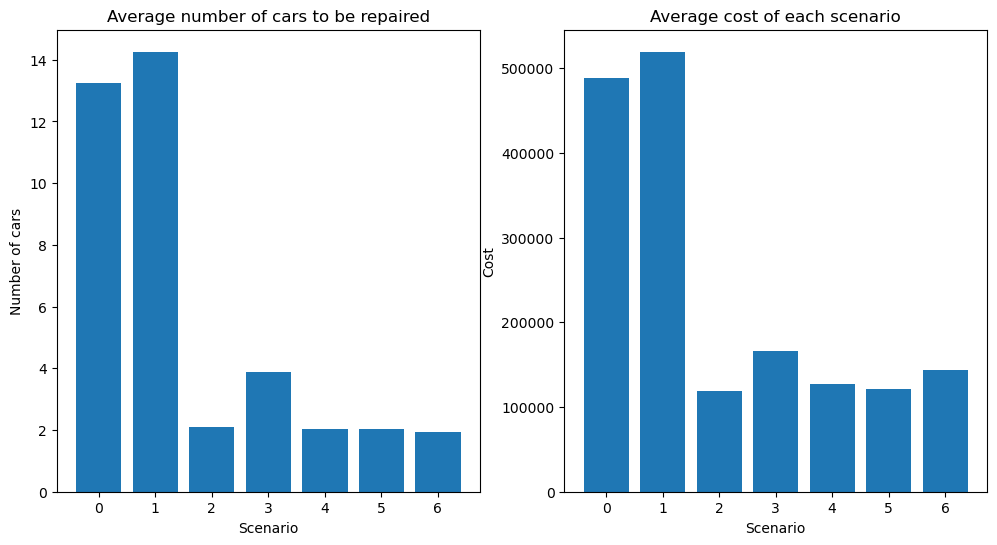

In [51]:
_, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].bar(range(7), mean_repair_ls)
axes[0].set(title='Average number of cars to be repaired',
            xlabel='Scenario',
            ylabel='Number of cars')

axes[1].bar(range(7), mean_cost_ls)
axes[1].set(title='Average cost of each scenario',
            xlabel='Scenario',
            ylabel='Cost')

plt.show()


In [52]:
sol = np.argmin(mean_cost_ls)
candidates = hr_df.columns[hr_df.loc[sol] == 1].tolist()

print(
    f"\nSo as the plots shows above the solution wiht lowes cost is the scenario {sol}, with the cost of ${mean_cost_ls[sol]}.\nMeanwhile the average number of cars in repair is {mean_repair_ls[sol].round(2)}.\nIn this scenario, the assign_matrix shows: \n{hr_df.loc[sol]==1},which means that {candidates} should be hired."
)



So as the plots shows above the solution wiht lowes cost is the scenario 2, with the cost of $118950.0.
Meanwhile the average number of cars in repair is 2.1.
In this scenario, the assign_matrix shows: 
Larry    False
Curly     True
Moe       True
Name: 2, dtype: bool,which means that ['Curly', 'Moe'] should be hired.
